In [1]:
import pandas as pd

# Carregando os dados de treinamento e teste
train_df = pd.read_csv("train_critic.csv").dropna()  # Carregando dados de treino
train_df = train_df.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(1500)).reset_index(drop=True)

/tmp/ipykernel_33701/2074655177.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(1500)).reset_index(drop=True)


In [2]:
from transformers import AutoTokenizer, Trainer, Trainer, TrainingArguments, AutoModelForSequenceClassification
import torch

NUM_LABELS = 2  # Número de classes
model_name = "google-bert/bert-base-uncased"  # Escolha o modelo conforme sua necessidade
tokenizer = AutoTokenizer.from_pretrained(model_name)  # Carregar o tokenizer
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS)  # Carregar o modelo de classificação

/home/felipedias/BigData/Trabalho1/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-20 18:09:45.604302: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 18:09:45.611518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732136985.621062   33701 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732136985.623886   33701 cuda_bla

In [3]:
from datasets import Dataset
import tensorflow as tf
import random
import numpy as np
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)


train_data_set = Dataset.from_pandas(train_df)
train_val_set = train_data_set.train_test_split (test_size = 0.2)

print(train_val_set)

x_train = train_val_set["train"]["Review"]
x_val = train_val_set["test"]["Review"]
y_train = train_val_set["train"]["Sentiment"]
y_val = train_val_set["test"]["Sentiment"] 



DatasetDict({
    train: Dataset({
        features: ['Show', 'Sentiment', 'Review'],
        num_rows: 2400
    })
    test: Dataset({
        features: ['Show', 'Sentiment', 'Review'],
        num_rows: 600
    })
})


In [4]:
train_encodings = tokenizer(list(x_train), truncation=True, padding=True, max_length=256)
valid_encodings = tokenizer(list(x_val), truncation=True, padding=True, max_length=256)

In [5]:
class DatasetLoader(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = DatasetLoader(train_encodings, list(y_train))
valid_dataset = DatasetLoader(valid_encodings, list(y_val))


In [6]:
from sklearn.metrics import balanced_accuracy_score

def compute_metrics(p):
    return {"balanced_accuracy": balanced_accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}

In [ ]:
training_args = TrainingArguments(
per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=35,
    logging_dir='./logs1',
    logging_steps=200,
    evaluation_strategy="steps",
    eval_steps=200,
    output_dir='./results1',
    learning_rate=0.00001,
    lr_scheduler_type="constant",
    remove_unused_columns=False,
)


/home/felipedias/BigData/Trabalho1/.venv/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [8]:
def make_model_contiguous(model):
    # Aplica .contiguous() a todos os tensores dos parâmetros do modelo
    for param in model.parameters():
        if not param.is_contiguous():
            param.data = param.data.contiguous()

In [9]:


make_model_contiguous(model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

In [10]:
trainer.train()

 10%|▉         | 500/5250 [00:51<08:08,  9.72it/s]

{'loss': 0.3066, 'grad_norm': 19.217201232910156, 'learning_rate': 1e-05, 'epoch': 3.33}


                                                  
 10%|▉         | 500/5250 [00:52<08:08,  9.72it/s]

{'eval_loss': 0.6094865798950195, 'eval_balanced_accuracy': 0.824843107311255, 'eval_runtime': 0.838, 'eval_samples_per_second': 715.989, 'eval_steps_per_second': 22.673, 'epoch': 3.33}


 19%|█▉        | 1000/5250 [01:45<07:16,  9.73it/s] 

{'loss': 0.0627, 'grad_norm': 4.548189163208008, 'learning_rate': 1e-05, 'epoch': 6.67}


                                                   
 19%|█▉        | 1000/5250 [01:46<07:16,  9.73it/s]

{'eval_loss': 1.054303765296936, 'eval_balanced_accuracy': 0.8097613447626266, 'eval_runtime': 0.8381, 'eval_samples_per_second': 715.913, 'eval_steps_per_second': 22.671, 'epoch': 6.67}


 29%|██▊       | 1500/5250 [02:38<06:25,  9.73it/s]

{'loss': 0.0149, 'grad_norm': 0.005793076008558273, 'learning_rate': 1e-05, 'epoch': 10.0}


                                                   
 29%|██▊       | 1500/5250 [02:39<06:25,  9.73it/s]

{'eval_loss': 1.1691068410873413, 'eval_balanced_accuracy': 0.8431463254227464, 'eval_runtime': 0.8338, 'eval_samples_per_second': 719.627, 'eval_steps_per_second': 22.788, 'epoch': 10.0}


 38%|███▊      | 2000/5250 [03:32<05:34,  9.71it/s]

{'loss': 0.0138, 'grad_norm': 0.003047002013772726, 'learning_rate': 1e-05, 'epoch': 13.33}


                                                   
 38%|███▊      | 2000/5250 [03:33<05:34,  9.71it/s]

{'eval_loss': 1.2701247930526733, 'eval_balanced_accuracy': 0.836898485135602, 'eval_runtime': 0.8395, 'eval_samples_per_second': 714.691, 'eval_steps_per_second': 22.632, 'epoch': 13.33}


 48%|████▊     | 2500/5250 [04:26<04:44,  9.66it/s]

{'loss': 0.0065, 'grad_norm': 0.0014263669727370143, 'learning_rate': 1e-05, 'epoch': 16.67}


                                                   
 48%|████▊     | 2500/5250 [04:27<04:44,  9.66it/s]

{'eval_loss': 1.374000906944275, 'eval_balanced_accuracy': 0.8326682346646453, 'eval_runtime': 0.8341, 'eval_samples_per_second': 719.298, 'eval_steps_per_second': 22.778, 'epoch': 16.67}


 57%|█████▋    | 3000/5250 [05:20<03:51,  9.71it/s]

{'loss': 0.0067, 'grad_norm': 0.0008259756141342223, 'learning_rate': 1e-05, 'epoch': 20.0}


                                                   
 57%|█████▋    | 3000/5250 [05:21<03:51,  9.71it/s]

{'eval_loss': 1.384036660194397, 'eval_balanced_accuracy': 0.8403038646319849, 'eval_runtime': 0.8402, 'eval_samples_per_second': 714.109, 'eval_steps_per_second': 22.613, 'epoch': 20.0}


 67%|██████▋   | 3500/5250 [06:14<03:01,  9.65it/s]

{'loss': 0.0078, 'grad_norm': 0.0008861715905368328, 'learning_rate': 1e-05, 'epoch': 23.33}


                                                   
 67%|██████▋   | 3500/5250 [06:15<03:01,  9.65it/s]

{'eval_loss': 1.4512072801589966, 'eval_balanced_accuracy': 0.8397353724738326, 'eval_runtime': 0.8362, 'eval_samples_per_second': 717.563, 'eval_steps_per_second': 22.723, 'epoch': 23.33}


 76%|███████▌  | 4000/5250 [07:08<02:09,  9.64it/s]

{'loss': 0.0182, 'grad_norm': 0.001149771618656814, 'learning_rate': 1e-05, 'epoch': 26.67}


                                                   
 76%|███████▌  | 4000/5250 [07:09<02:09,  9.64it/s]

{'eval_loss': 1.3700978755950928, 'eval_balanced_accuracy': 0.8445954230807816, 'eval_runtime': 0.8346, 'eval_samples_per_second': 718.883, 'eval_steps_per_second': 22.765, 'epoch': 26.67}


 86%|████████▌ | 4500/5250 [08:01<01:17,  9.72it/s]

{'loss': 0.0059, 'grad_norm': 0.0005297204479575157, 'learning_rate': 1e-05, 'epoch': 30.0}


                                                   
 86%|████████▌ | 4500/5250 [08:02<01:17,  9.72it/s]

{'eval_loss': 1.5515875816345215, 'eval_balanced_accuracy': 0.8355106954554068, 'eval_runtime': 0.8358, 'eval_samples_per_second': 717.856, 'eval_steps_per_second': 22.732, 'epoch': 30.0}


 95%|█████████▌| 5000/5250 [08:55<00:26,  9.61it/s]

{'loss': 0.0051, 'grad_norm': 0.0003698859945870936, 'learning_rate': 1e-05, 'epoch': 33.33}


                                                   
 95%|█████████▌| 5000/5250 [08:56<00:26,  9.61it/s]

{'eval_loss': 1.8550634384155273, 'eval_balanced_accuracy': 0.8162098293408835, 'eval_runtime': 0.8357, 'eval_samples_per_second': 717.923, 'eval_steps_per_second': 22.734, 'epoch': 33.33}


100%|██████████| 5250/5250 [09:25<00:00,  9.29it/s]

{'train_runtime': 565.1242, 'train_samples_per_second': 148.64, 'train_steps_per_second': 9.29, 'train_loss': 0.04339522507077172, 'epoch': 35.0}


TrainOutput(global_step=5250, training_loss=0.04339522507077172, metrics={'train_runtime': 565.1242, 'train_samples_per_second': 148.64, 'train_steps_per_second': 9.29, 'total_flos': 3280665971520000.0, 'train_loss': 0.04339522507077172, 'epoch': 35.0})

In [11]:
df_loss = pd.DataFrame(columns=['epoch', 'loss'])
df_val_loss = pd.DataFrame(columns=['epoch', 'eval_loss','eval_balanced_accuracy'])

for values in trainer.state.log_history:
    if values.get('loss') is not None:
         df_new_row = pd.DataFrame.from_records({'epoch': values['epoch'], 'loss': values['loss']}, index=[0])
         df_loss = pd.concat([df_loss, df_new_row], ignore_index=True)
    elif values.get('train_loss') is not None:
         df_new_row = pd.DataFrame.from_records({'epoch': values['epoch'], 'loss': values['train_loss']}, index=[0])
         df_loss = pd.concat([df_loss, df_new_row], ignore_index=True)
    elif values.get('eval_loss') is not None:
         df_val_new_row = pd.DataFrame.from_records({'epoch': values['epoch'], 'eval_loss': values['eval_loss'], 'eval_balanced_accuracy': values['eval_balanced_accuracy']}, index=[0])
         df_val_loss = pd.concat([df_val_loss, df_val_new_row], ignore_index=True)

mergedDf = pd.merge(df_loss, df_val_loss)


/tmp/ipykernel_33701/3409307734.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_loss = pd.concat([df_loss, df_new_row], ignore_index=True)
/tmp/ipykernel_33701/3409307734.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_val_loss = pd.concat([df_val_loss, df_val_new_row], ignore_index=True)


In [12]:
print(mergedDf)

       epoch    loss  eval_loss  eval_balanced_accuracy
0   3.333333  0.3066   0.609487                0.824843
1   6.666667  0.0627   1.054304                0.809761
2  10.000000  0.0149   1.169107                0.843146
3  13.333333  0.0138   1.270125                0.836898
4  16.666667  0.0065   1.374001                0.832668
5  20.000000  0.0067   1.384037                0.840304
6  23.333333  0.0078   1.451207                0.839735
7  26.666667  0.0182   1.370098                0.844595
8  30.000000  0.0059   1.551588                0.835511
9  33.333333  0.0051   1.855063                0.816210


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

def  plot_loss_accuracy(df):
    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    sns.lineplot(data=df[['loss', 'eval_loss']])

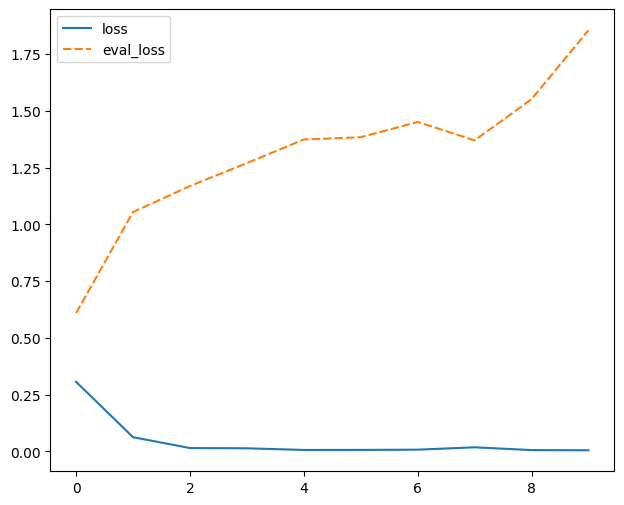

In [14]:
plot_loss_accuracy(mergedDf)

In [15]:
from sklearn import metrics

def plot_confusion_matrix(dataset, predictions, labels=None):
    #calcula a acurácia balanceada
    labels = dataset['Sentiment']
    preds = [0 if pred['label'] == 'LABEL_0' else 1 for pred in predictions]
    
    
    print('balanced Accuracy:', balanced_accuracy_score(labels, preds))
    print('accuracy', metrics.accuracy_score(labels, preds))

    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(labels, preds)
    r = c / c.sum(axis=1, keepdims=True)

    plt.figure(figsize=(10, 8))
    sns.heatmap(r, annot=True, fmt=".2f", cmap="Blues")
    plt.xlabel("Classe predita")
    plt.ylabel("Classe verdadeira")
    plt.title("Matriz de confusão relativa")
    plt.show()

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


balanced Accuracy: 0.8468025102830199
accuracy 0.8483333333333334


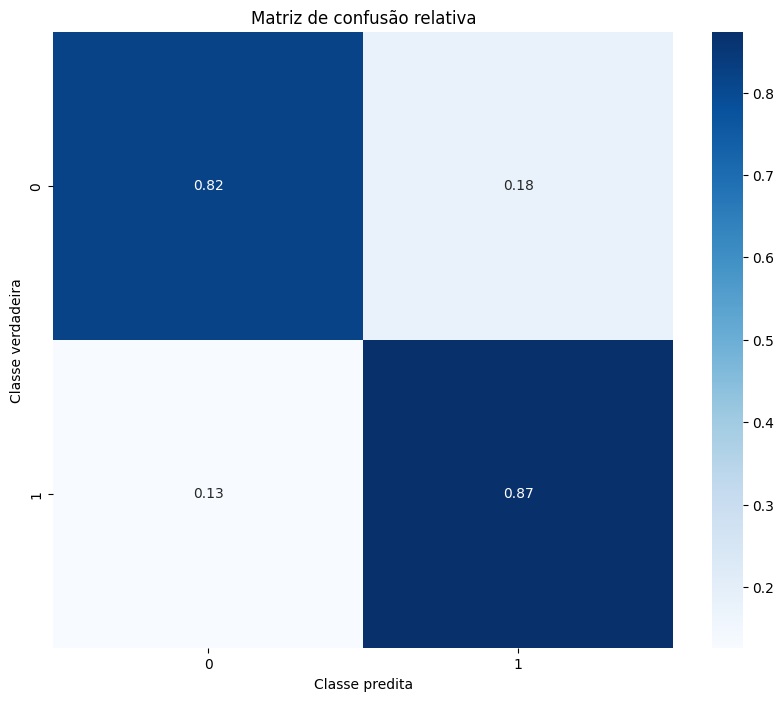

In [16]:
from transformers import pipeline
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)

predictions = classifier(train_val_set["test"]["Review"], batch_size=16)


plot_confusion_matrix(train_val_set["test"], predictions)
